In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import prepare_inference_combined
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

In [2]:
blue = '#1F449C'
pink = '#E57A77'

In [3]:
def stats_comparison_plot(conjugate, combined, rng):
    color_combined = pink
    color_conjugate = blue
    plt.axvline(x=sps.describe(conjugate).mean, color=color_conjugate, label='Conjugate')
    plt.axvspan(xmin=(sps.describe(conjugate).mean - sps.iqr(conjugate, rng=rng))[0], xmax=(sps.describe(conjugate).mean + sps.iqr(conjugate, rng=rng))[0], alpha=0.6, color=color_conjugate)#, label='Conjugate std')
    plt.axvline(x=sps.describe(combined).mean, color=color_combined, label='Combined')
    plt.axvspan(xmin=(sps.describe(combined).mean - sps.iqr(combined, rng=rng))[0], xmax=(sps.describe(combined).mean + sps.iqr(combined, rng=rng))[0], alpha=0.6, color=color_combined)#, label='Combined std')
    plt.legend()
    plt.title(f'{len(combined)} Draws, range = {rng}')

## Comparing Combined / Conjugate for Poisson Constraints

Attention: Use the pm.Poiss distribution in infer.py

In [54]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[10, 10], bkg=[120, 120], bkg_uncertainty=[12, 12]
)
data = [150, 150]
auxdata = model.config.auxdata

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    # 'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

n_draws = 5_000

In [44]:
model.expected_auxdata([1])

Array([100., 100.], dtype=float64)

#### Conjugate


In [62]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [uncorr_bkguncrt]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 3 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (5000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


#### Combined


In [63]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1 , step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    prior_pred_combined = pm.sample_prior_predictive(10_000)

ValueError: Incompatible Elemwise input shapes [(2,), (3,)]

#### Comparison Posterior

ValueError: Provided figure has 9 axes, but data has dimensions K=6

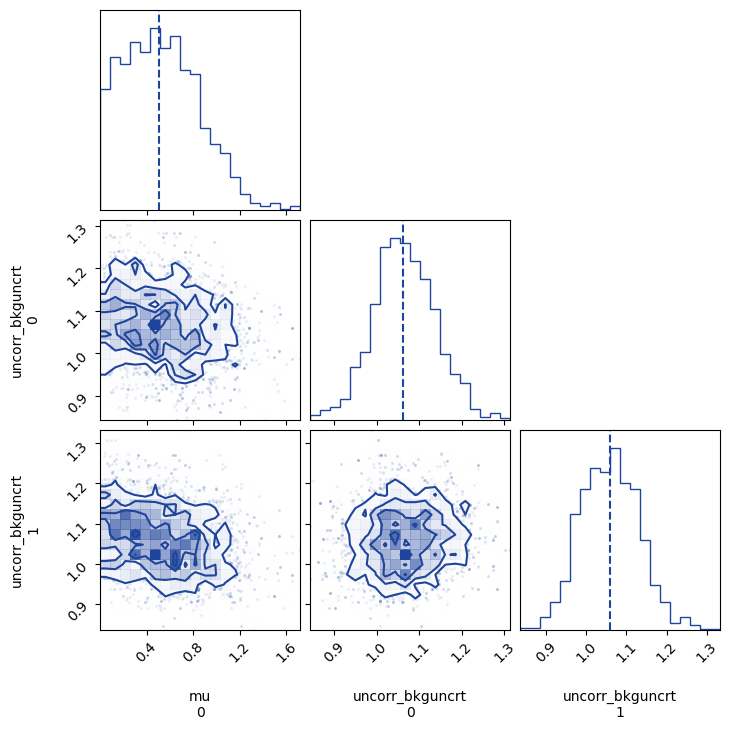

In [57]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

In [59]:
combined = [post_data.posterior.uncorr_bkguncrt.T[0], post_data.posterior.uncorr_bkguncrt.T[1]]
conjugate = [post_data_combined.posterior.Gammas.T[0], post_data_combined.posterior.Gammas.T[1]]

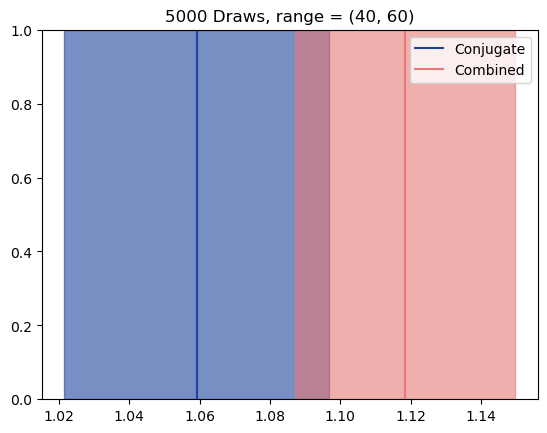

In [60]:
# HMC
stats_comparison_plot(combined[1], conjugate[1], rng=(40, 60))

## Combined / Conjugate for Normal constraints

Attention: Use the pm.Normal distribution in infer.py

In [267]:
model = pyhf.simplemodels.correlated_background(
    signal=[10, 10],
    bkg=[120, 140],
    bkg_up=[130, 160],
    bkg_down=[100, 120]
    )
data = [140, 180]
auxdata = model.config.auxdata

n_draws = 50_000

In [268]:
unconstr_priors = {
    # 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

#### Conjugate

In [269]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [correlated_bkg_uncertainty]
>Metropolis: [mu]


Sampling 1 chain for 1_000 tune and 50_000 draw iterations (1_000 + 50_000 draws total) took 19 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (50000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


#### Combined

In [270]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_Gammas]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 50_000 draw iterations (1_000 + 50_000 draws total) took 23 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (50000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [275]:
combined = [post_data.posterior.correlated_bkg_uncertainty.T[0]]
conjugate = [post_data_combined.posterior.Normals.T[0]]

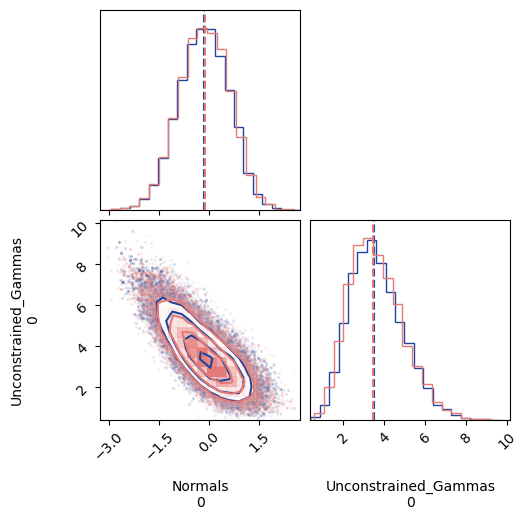

In [276]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

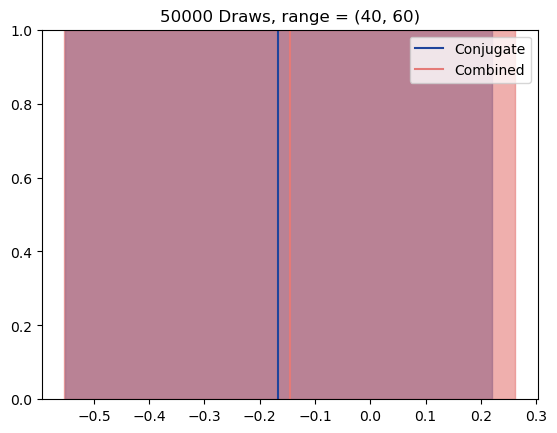

In [277]:
stats_comparison_plot(combined[0], conjugate[0], rng=(40, 60))